# Clustering

### Γιώργος Λεβαντής Α.Μ 2744
### Παναγιώτης Τσιάβος Α.Μ. 2396

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# from sklearn.metrics import jaccard_score
import sklearn.metrics as metrics

sns.set_style("darkgrid")
%matplotlib inline

In [2]:
df = pd.read_json('train.json')
df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


Οι κουζίνες που θα εξετάσουμε ειναι 'british'(804), 'korean'(830) και moroccan'(821).Οι οποίες συνολικά εχουν 2090 (μοναδικά) υλικά 

In [3]:
df.groupby('cuisine').count()

,id,ingredients
cuisine,,
brazilian,467,467
british,804,804
cajun_creole,1546,1546
chinese,2673,2673
filipino,755,755
french,2646,2646
greek,1175,1175
indian,3003,3003
irish,667,667


In [4]:
target_cuisines =['british', 'korean', 'moroccan']

In [5]:
df = df[df['cuisine'].isin(target_cuisines) ]
df.head()

,id,cuisine,ingredients
16,34466,british,"[greek yogurt, lemon curd, confectioners sugar..."
66,8530,korean,"[jasmine rice, garlic, scallions, sugar, shiit..."
72,699,moroccan,"[ground cloves, whole nutmegs, ground ginger, ..."
75,16582,moroccan,"[tumeric, olive oil, lemon, saffron, tomato pa..."
76,9058,moroccan,"[ground pepper, paprika, ground cardamom, chop..."


In [6]:
l = list()
for i,r in df.iterrows():
    for j in r['ingredients']:
        if j not in l:
            l.append(j)

In [7]:
print("Amount of unique ingredients in subset: ",len(l))

Amount of unique ingredients in subset:  2090


### CountVectorizer

Με χρήση του CountVectorizer εξάγουμε τα υλικά και έτσι παίρνουμε τον τελικό πίνακα Μ, όπου γραμμές οι συνταγές, στήλες τα υλικά

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
import re
import sys

In [9]:
def sub_space(x):
    temp_value = list()
    for i in x:
        temp_value.append(re.sub(r'[^0-9a-zA-Z]+','_',i.lower()))
    return temp_value

df['ingredients_new'] = df['ingredients'].apply(sub_space)

In [10]:
def convert_list_to_sent(x):
    return ' '.join(x)

df['ingredient_sent'] = df['ingredients_new'].apply(convert_list_to_sent)

In [11]:
count = CountVectorizer()
M = count.fit_transform(df['ingredient_sent'])

In [12]:
M.shape

(2455, 2088)

## K means

Εφραμόζωντας των K-means++ στον πίνακα M με n_clusters=3, ο αλγόριθμος αντιστοιχεί κάθε συνταγή (γραμμή του Μ) σε ενα Cluster (kmeans.labels_), και για κάθε cluster έχουμε τιμές ως προς κάθε υλικό (kmeans.cluster_centers_) το οποίο δηλώνει τη σημασία ενός υλικού στο αντίστοιχο cluster.  

<b>Το πρόβλημα που τίθεται τώρα ειναι να καταλάβουμε σε ποια κουζίνα αντιστοιχεί το κάθε cluster.</b>

In [13]:
import sklearn.cluster as sk_cluster
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,classification_report

In [14]:
kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=3)
kmeans.fit_predict(M)
centroids = kmeans.cluster_centers_
kmeans_labels = kmeans.labels_
error = kmeans.inertia_

print ("The total error of the clustering is: ", error)
print ('\nCluster labels')
print(kmeans_labels)
print ('\n Cluster Centroids')
print (centroids)

The total error of the clustering is:  23938.62754087301

Cluster labels
[2 1 0 ... 2 0 2]

 Cluster Centroids
[[0.00157729 0.         0.         ... 0.00157729 0.0126183  0.05520505]
 [0.         0.         0.         ... 0.         0.         0.05610561]
 [0.         0.00246914 0.00082305 ... 0.         0.00823045 0.02057613]]


Ένας τρόπος ανάθεσεις θα ήταν να συγκρίνουμε τα τοπ υλικά του κάθε cluster με τα τοπ υλικά τις κάθε κουζίνας. Παρακάτω βλέπουμε αυτα τα τοπ υλικά και όντως μπορεί κανείς και με το μάτι να καταλάβει σε ποιά κουζίνα αντιστοιχεί.

In [15]:
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = count.get_feature_names()
for i in range(3):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: olive_oil salt ground_cumin onions garlic_cloves ground_cinnamon ground_ginger ground_black_pepper paprika water
Cluster 1: soy_sauce sesame_oil garlic green_onions sugar sesame_seeds water onions salt scallions
Cluster 2: salt sugar all_purpose_flour butter eggs milk unsalted_butter water onions large_eggs


In [16]:
from collections import Counter
counters = {}
for cuisine in df['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (df['cuisine'] == cuisine)
    for ingredients in df[indices]['ingredients']:
        counters[cuisine].update(ingredients)

In [17]:
for i in target_cuisines:
    print(i,':')
    print(counters[i].most_common(10),'\n')

british :
[('salt', 407), ('all-purpose flour', 238), ('butter', 222), ('milk', 202), ('eggs', 191), ('unsalted butter', 191), ('sugar', 176), ('onions', 142), ('baking powder', 122), ('large eggs', 110)] 

korean :
[('soy sauce', 427), ('sesame oil', 403), ('garlic', 303), ('green onions', 293), ('sugar', 266), ('salt', 253), ('water', 242), ('sesame seeds', 223), ('onions', 208), ('scallions', 196)] 

moroccan :
[('salt', 413), ('olive oil', 412), ('ground cumin', 348), ('onions', 280), ('ground cinnamon', 223), ('garlic cloves', 223), ('water', 182), ('ground ginger', 175), ('carrots', 155), ('paprika', 150)] 



Σε αυτήν την άσκηση βέβαια η αντιστοίχιση εγινε με την βοήθεια μια συνάρτησης που  αντιστοιχεί κάθε cluster στην τάξη που έχει τους περισσότερους πόντους.  

Για να γίνει αυτη η αντιστοίχιση δημιουργήσαμε μια στήλη 'Cluster' τα οποια ειναι τα true labels των κουζινών (με βάση το indice στη λίστα target_cuisines). Επομένως όπου:
- Cluster 0: 'british'
- Cluster 1: 'korean'
- Cluster 2: 'moroccan'

In [18]:
df['Cluster'] = df['cuisine'].apply(lambda cuisine: target_cuisines.index(cuisine))

In [19]:
df[['cuisine','Cluster']].head()

,cuisine,Cluster
16,british,0
66,korean,1
72,moroccan,2
75,moroccan,2
76,moroccan,2


Παρακάτω βλέπουμε τον πίνακα συγχυσης καθώς και τα precision/recall:
- <b>Precision</b>: η ικανότητα ενός classifier να μην επισημάνει μια θετική περίπτωση που είναι πραγματικά αρνητική (η αναλογία των αληθινών θετικών προς το άθροισμα των αληθινών και ψευδών θετικών). Με άλλα λόγια "για όλες τις περιπτώσεις που ταξινομούνται θετικά, ποιο ποσοστό ήταν σωστό;"
- <b>Recall</b>: η ικανότητα ενός classifier να βρει όλες τις θετικές περιπτώσεις. Με άλλα λόγια "για όλες τις περιπτώσεις που ήταν πραγματικά θετικές, ποιο ποσοστό κατατάχθηκε σωστά;"

Επομένως για το:
- Cluster 0 (british): κατατάσει μερικές κουζίνες ως british παρόλον που δεν ειναι (precision=0.64), αλλά βρίσκει σχεδόν ολες της 'british' κουζίνες (recall=0.97).
- Cluster 1 (korean): όλες οι κουζίνες που έχει θέσει ως 'korean' ειναι σωστές (precision=1.00), αλλα γενικά δεν βρέθηκαν ολες οι korean κουζίνες (recall=0.73)
- Cluster 2 (moroccan): σχεδόν όλες οι κουζίνες που έχει θέσει ως 'moroccan' ειναι σωστές (precision=0.96), αλλα γενικά δεν βρέθηκαν ολες οι moroccan κουζίνες (recall=0.75)

In [20]:
def cluster_class_mapping(kmeans_labels,true_labels):
    C= metrics.confusion_matrix(kmeans_labels,true_labels)
    mapping = list(np.argmax(C,axis=1))
    mapped_kmeans_labels = [mapping[l] for l in kmeans_labels]
    C2= metrics.confusion_matrix(mapped_kmeans_labels,true_labels)
    return mapped_kmeans_labels,C2

mapped_kmeans_labels,C = cluster_class_mapping(kmeans_labels,df['Cluster'])
print(C)

[[779 226 210]
 [  1 603   2]
 [ 24   1 609]]


In [21]:
print(classification_report(df['Cluster'],mapped_kmeans_labels))

              precision    recall  f1-score   support

           0       0.64      0.97      0.77       804
           1       1.00      0.73      0.84       830
           2       0.96      0.74      0.84       821

    accuracy                           0.81      2455
   macro avg       0.87      0.81      0.82      2455
weighted avg       0.87      0.81      0.82      2455



In [22]:
#Another way to calculate precision/recall
p = metrics.precision_score(df['Cluster'],mapped_kmeans_labels, average=None)
print(p)
r = metrics.recall_score(df['Cluster'],mapped_kmeans_labels, average = None)
print(r)

[0.64115226 0.9950495  0.96056782]
[0.96890547 0.72650602 0.74177832]


### Visualizing data-Kmeans

Παρακάτω βλέπουμε πως είνα πραγματικα τα δεδομένα μας και πως τα αντιστοιχεί ο K-means.  

Παρατήρηση:
- Απο το scatter με τα κανονικά δεδομένα βλέπουμε οτι υπάρχουν συνταγές οι οποίες δεν ξεχωρίζουν πολύ στις κουζίνες (κέντρο του scatter).
- Οι κουζίνες british και morrocan εχουν μερικές συνταγές που μοιάζουν με την αντίστοιχη κουζινα (μερικα σημεία του moroccan ειναι μεταξύ πολλα british και ανάποδα. 

In [23]:
pca = PCA(n_components=2).fit(M.toarray())
# pca = PCA(n_components=3).fit(M.toarray())
data = pca.transform(M.toarray())
centers2D = pca.transform(kmeans.cluster_centers_)


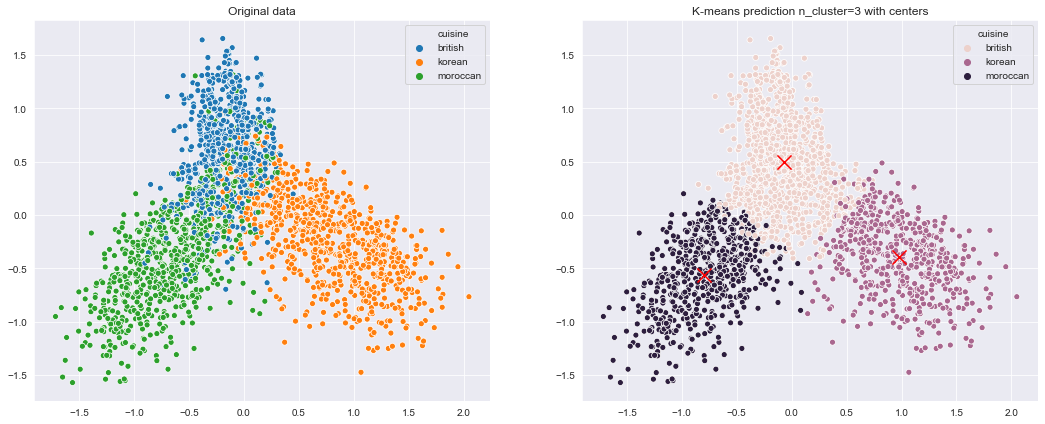

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18, 7)

ax1.set_title("Original data")
ax2.set_title("K-means prediction n_cluster=3 with centers")
sns.scatterplot(data[:, 0], data[:, 1], hue=df['cuisine'], ax=ax1)
sns.scatterplot(data[:, 0], data[:, 1], hue=mapped_kmeans_labels, ax=ax2)
ax2.scatter(centers2D[:,0], centers2D[:,1], marker='x', s=200, linewidths=3, c='r')

L=ax2.get_legend()
L.set_title('cuisine')
for i,c in enumerate(target_cuisines):
    L.get_texts()[i].set_text(c)


Βλέπουμε ότι όσο αυξάνεται ο αριμθμός των cluster τα error μειώνονται (-500 errors per cluster), ομώς αντίστοιχα πέφτει και το silhouette score.  


Γενικά το silhouette score κυμαίνεται από -1 έως +1, όπου μια υψηλή τιμή υποδεικνύει ότι το αντικείμενο είναι καλά προσαρμοσμένο στο δικό του σύμπλεγμα και δεν ταιριάζει με τα γειτονικά σύνολα. Εάν τα περισσότερα αντικείμενα έχουν υψηλή τιμή, τότε η διαμόρφωση συμπλέγματος είναι κατάλληλη.

Text(0, 0.5, 'Error')

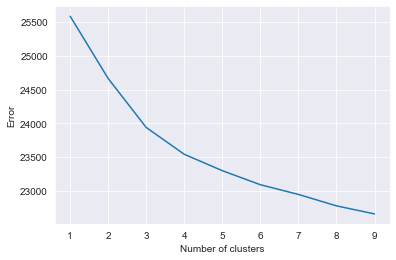

In [25]:
error = np.zeros(10)
sh_score = np.zeros(10)
for k in range(1,10):
    km = sk_cluster.KMeans(init='k-means++', n_clusters=k)
    km.fit_predict(M)
    error[k] = km.inertia_
    if k>1: sh_score[k]= metrics.silhouette_score(M, km.labels_)

plt.plot(range(1,len(error)),error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('Error')

Text(0, 0.5, 'silhouette score')

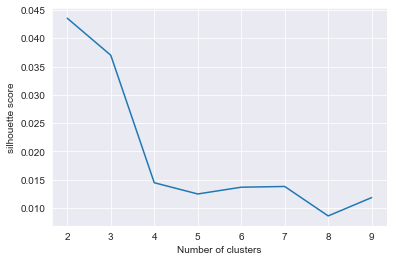

In [26]:
plt.plot(range(2,len(sh_score)),sh_score[2:])
# plt.set_title("")
plt.xlabel('Number of clusters')
plt.ylabel('silhouette score')

### Silhouette Plot

Οι συντελεστές σιλουέτας κοντά στο +1 υποδηλώνουν ότι το δείγμα απέχει πολύ από τα γειτονικά σύνολα. Μια τιμή 0 υποδεικνύει ότι το δείγμα είναι πολύ κοντά στο όριο απόφασης μεταξύ δύο γειτονικών ομάδων και οι αρνητικές τιμές υποδεικνύουν ότι τα δείγματα αυτά ενδέχεται να έχουν αντιστοιχιστεί σε λάθος σύμπλεγμα.

Η γραφική παράσταση σιλουέτας δείχνει στις περισσότερες τιμές του n_clusters είναι μια κακή επιλογή για τα δεδομένα  λόγω της παρουσίας συστάδων με υποβαθμισμένες βαθμολογίες σιλουέτας και επίσης λόγω των μεγάλων διακυμάνσεων στο μέγεθος των διαγραμμάτων σιλουέτας.

<u><b>Η ανάλυση Silhouette είναι πιο καλή όταν αποφασίζει για n_cluster=3.</b></u>

For n_clusters = 2 The average silhouette_score is : 0.043546209492206965
For n_clusters = 3 The average silhouette_score is : 0.037677450415759005
For n_clusters = 4 The average silhouette_score is : 0.014268043291011423
For n_clusters = 5 The average silhouette_score is : 0.015713446894402835
For n_clusters = 6 The average silhouette_score is : 0.013093033026195586
For n_clusters = 7 The average silhouette_score is : 0.010862350635947454
For n_clusters = 8 The average silhouette_score is : 0.006923731475524219
For n_clusters = 9 The average silhouette_score is : 0.011151758340833247


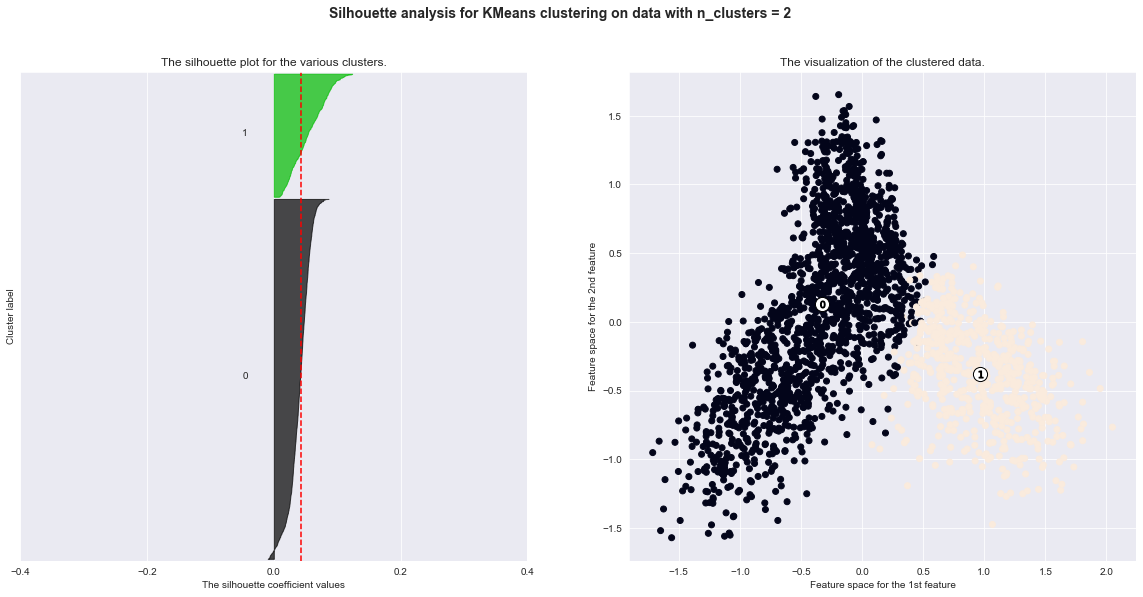

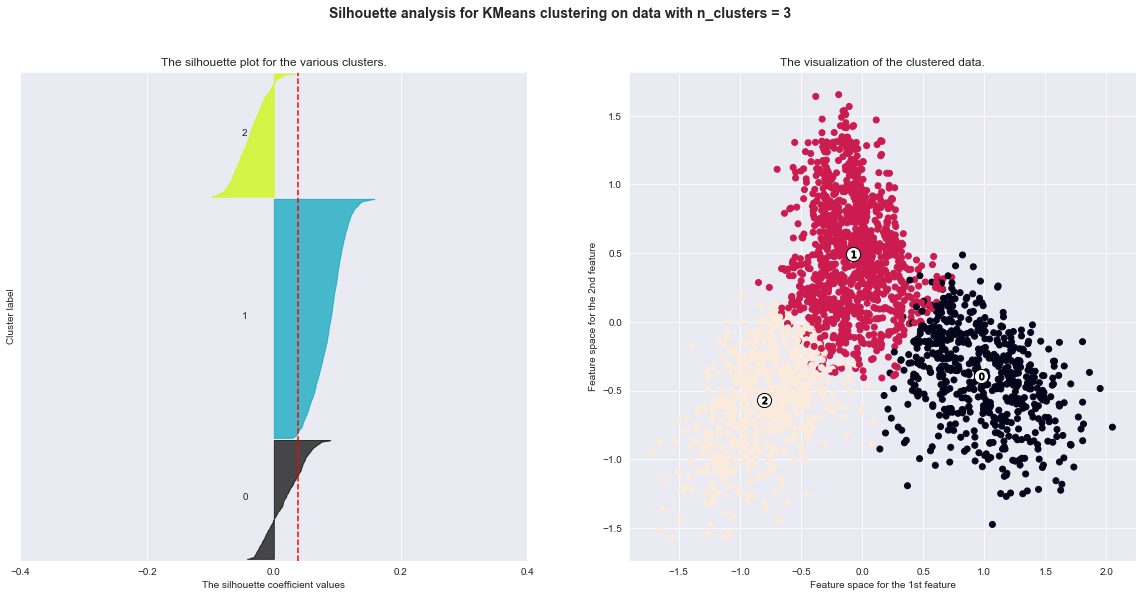

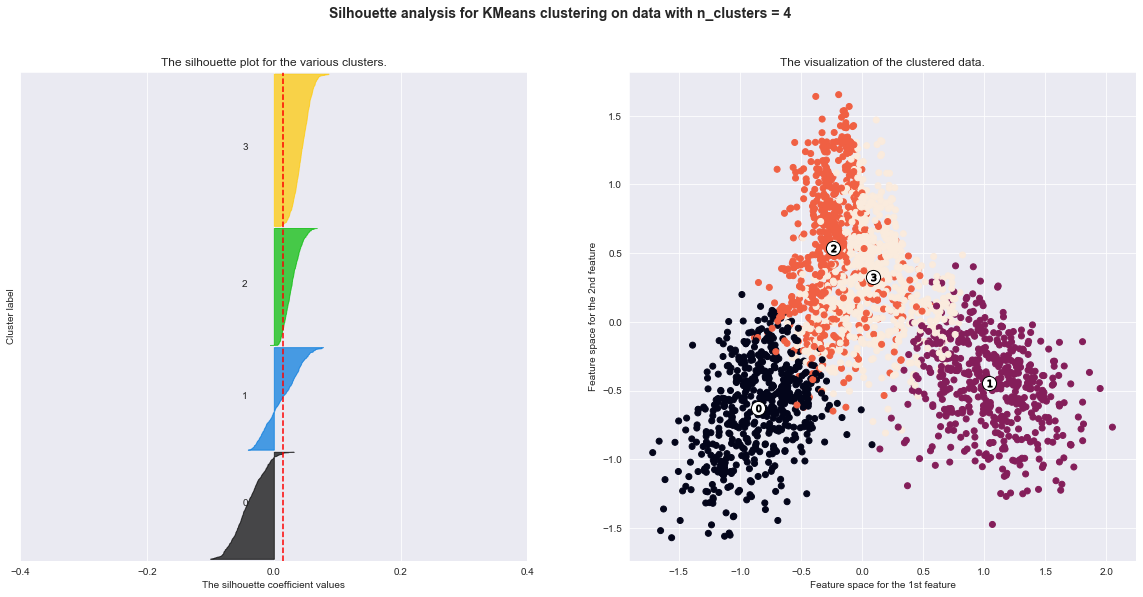

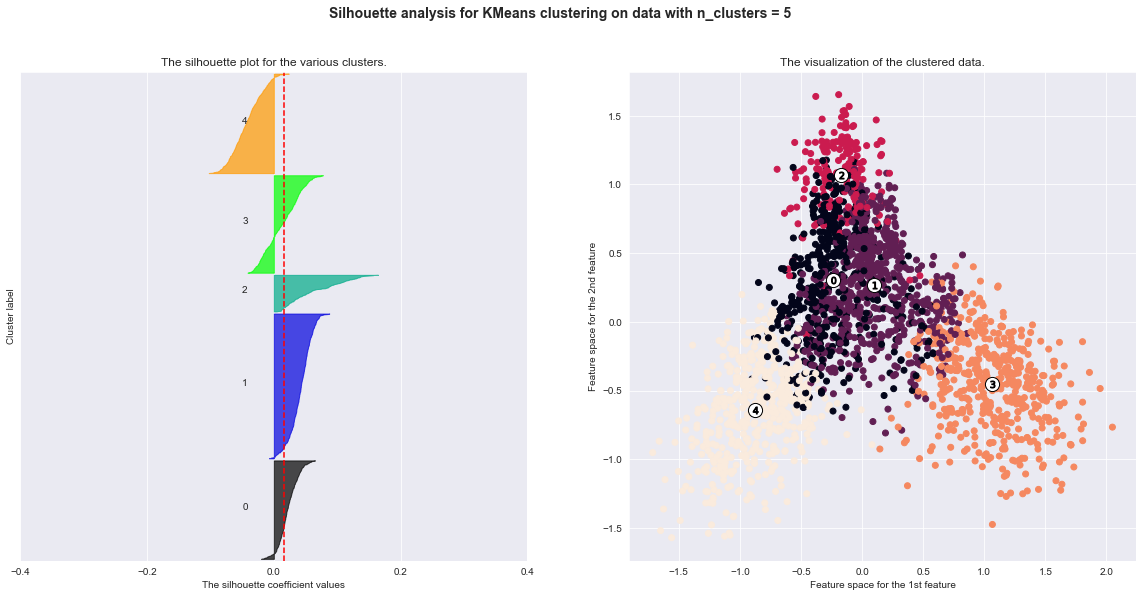

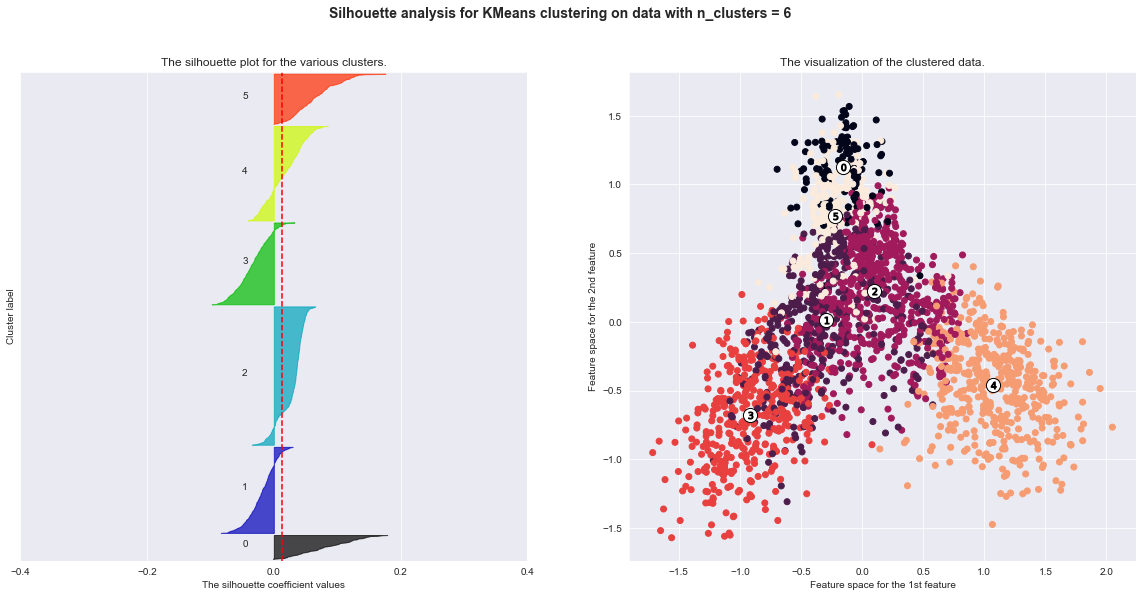

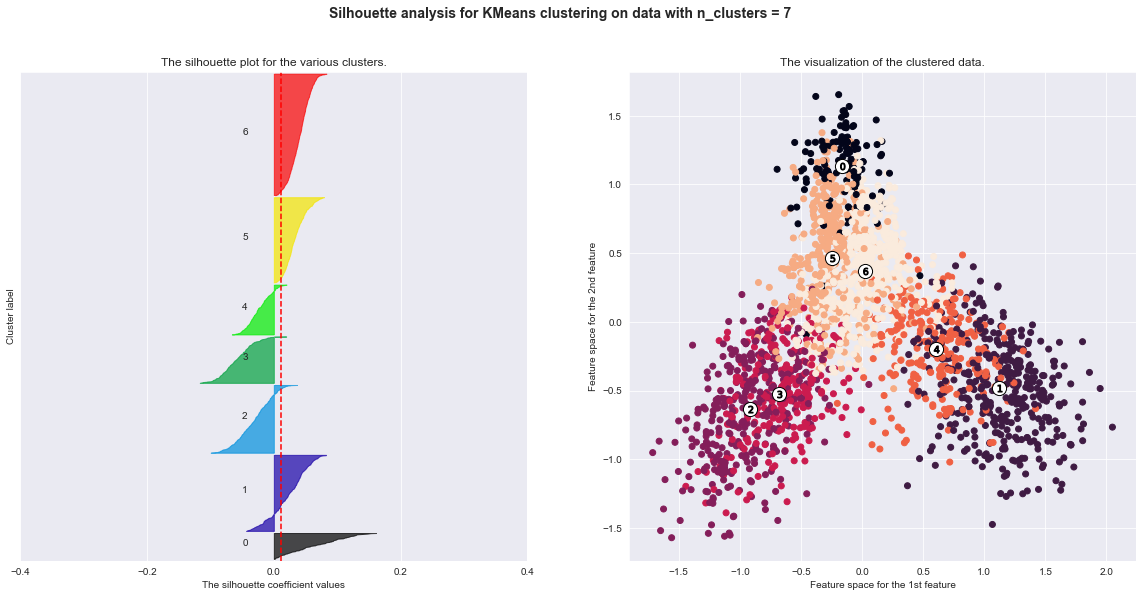

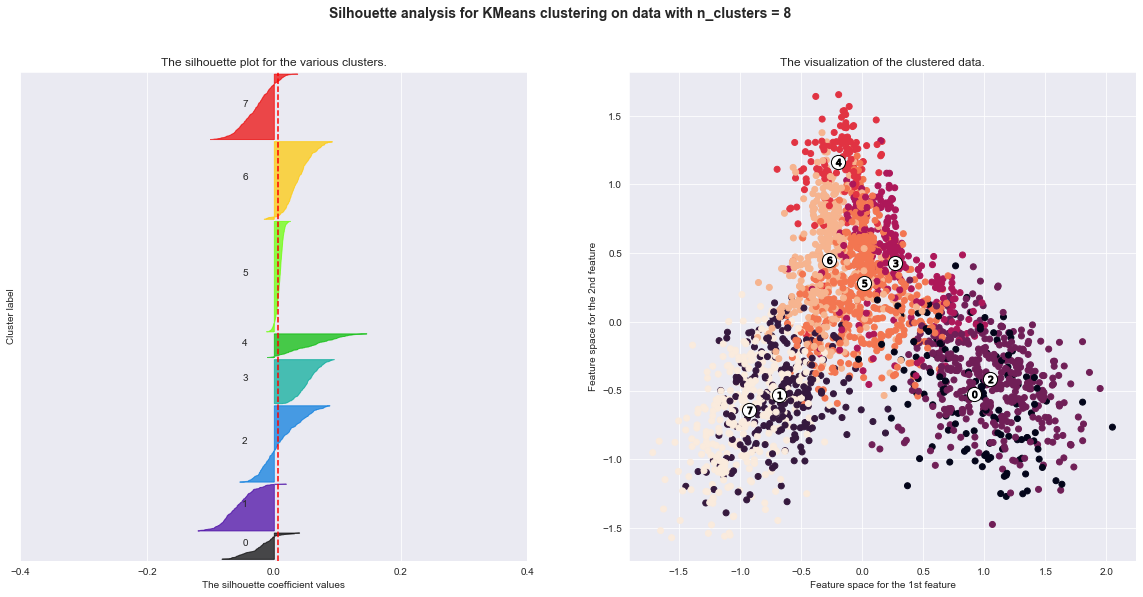

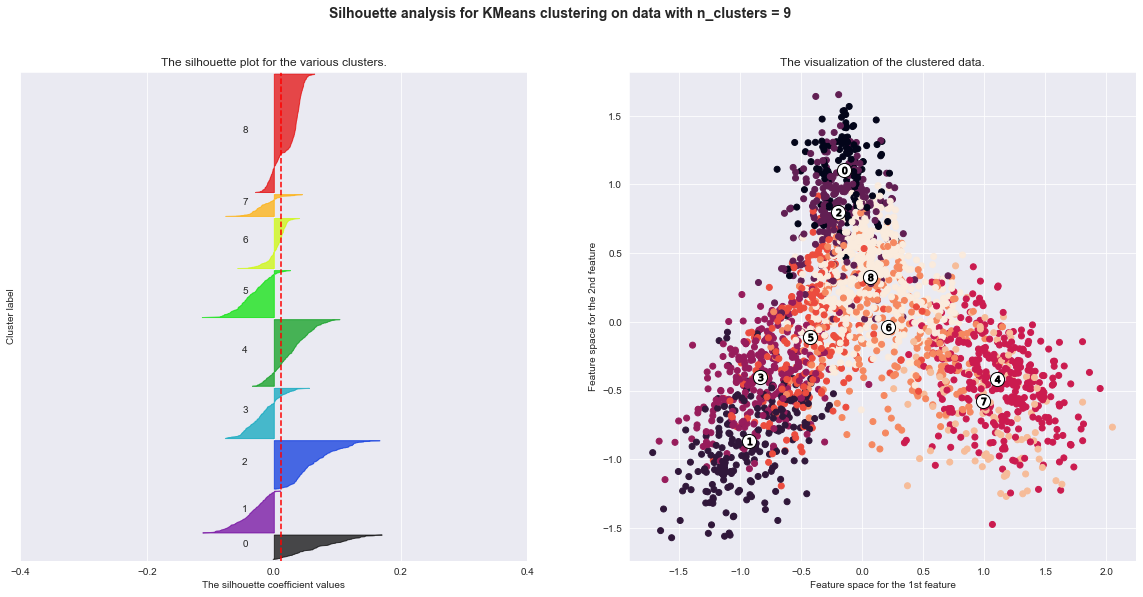

In [27]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm



# range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]

for n_clusters in range(2,10):

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 9)

    ax1.set_xlim([-0.4, 0.4])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, M.shape[0] + (n_clusters + 1) * 10])

    clusterer = sk_cluster.KMeans(init='k-means++',n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(M)
    
#     if(n_clusters>2):
#         cluster_labels,_ = cluster_class_mapping(clusterer.labels_,df['Cluster'])
#         cluster_labels = np.array(cluster_labels)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(M, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(M, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.4,-0.2, 0, 0.2, 0.4])

    # Linear dimensionality reduction for plotting
    pca = PCA(n_components=n_clusters).fit(M.toarray())
    data2D = pca.transform(M.toarray())
    
    # 2nd Plot showing the actual clusters formed
    ax2.scatter(data2D[:, 0], data2D[:, 1], c=clusterer.labels_)


    # Labeling the clusters    
    centers2D = pca.transform(clusterer.cluster_centers_)

    # Draw white circles at cluster centers
    ax2.scatter(centers2D[:, 0], centers2D[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers2D):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
        
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')



## Agglomerative Clustering

- Cluster 0 (british): κατατάσει μερικές κουζίνες ως british παρόλον που δεν ειναι (precision=0.67, αλλά βρίσκει σχεδόν ολες της 'british' κουζίνες (recall=0.95.
- Cluster 1 (korean): όλες οι κουζίνες που έχει θέσει ως 'korean' ειναι σωστές (precision=1.00), αλλα γενικά δεν βρέθηκαν ολες οι korean κουζίνες (recall=0.75
- Cluster 2 (moroccan): σχεδόν όλες οι κουζίνες που έχει θέσει ως 'moroccan' ειναι σωστές (precision=.96 αλλα γενικά δεν βρέθηκαν ολες οι moroccan κουζίνες (recall=0.79)

Επομένως ο Agglomerative δεν διαφέρει και πολύ απο τον K-means (λιγο καλύτερo recall στο Agglomerative, επειδή μπορεί να βρει λίγο καλύτερα τις συνταγές μεταξύ British-Moroccan)

In [28]:
%%time
agglo = sk_cluster.AgglomerativeClustering(linkage = 'ward',n_clusters = 3)
agglo_labels = agglo.fit_predict(M.todense())

Wall time: 9.14 s


In [29]:
C_agglo= metrics.confusion_matrix(agglo_labels,df['Cluster'])
print (C_agglo)


mapped_agglo_labels,C_agglo = cluster_class_mapping(agglo_labels,df['Cluster'])
print(C_agglo)
p = metrics.precision_score(df['Cluster'],mapped_agglo_labels, average='weighted')
print(p)
r = metrics.recall_score(df['Cluster'],mapped_agglo_labels, average = 'weighted')
print(r)

[[766 203 169]
 [  2 625   1]
 [ 36   2 651]]
[[766 203 169]
 [  2 625   1]
 [ 36   2 651]]
0.8728863279303424
0.8317718940936863


In [30]:
print(classification_report(df['Cluster'],mapped_agglo_labels))

              precision    recall  f1-score   support

           0       0.67      0.95      0.79       804
           1       1.00      0.75      0.86       830
           2       0.94      0.79      0.86       821

    accuracy                           0.83      2455
   macro avg       0.87      0.83      0.84      2455
weighted avg       0.87      0.83      0.84      2455



In [31]:
pca = PCA(n_components=2).fit(M.toarray())
data = pca.transform(M.toarray())


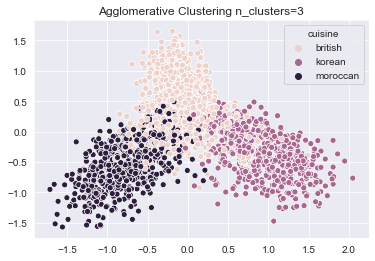

In [32]:
algo_ax = sns.scatterplot(data[:,0],data[:,1], hue=mapped_agglo_labels)
algo_ax.set_title("Agglomerative Clustering n_clusters=3")

L=algo_ax.get_legend()
L.set_title('cuisine')
for i,c in enumerate(target_cuisines):
    L.get_texts()[i].set_text(c)